In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
import numpy as np

In [ ]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match the original input size
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define the pre-trained model
class PretrainedModel(torch.nn.Module):
    def __init__(self):
        super(PretrainedModel, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = torch.nn.Linear(512, 10)  # Change the last layer for CIFAR-10

    def forward(self, x):
        return self.model(x)

In [ ]:
# Function to visualize an image
def imshow(img, title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
# Saliency map
def saliency_map(image, model):
    model.eval()
    image.requires_grad = True
    output = model(image)
    model.zero_grad()
    target_index = output.argmax()
    output[0, target_index].backward()
    saliency_map = image.grad.detach().cpu().numpy()[0]
    saliency_map = np.abs(saliency_map).max(axis=0)
    saliency_map -= saliency_map.min()
    saliency_map /= saliency_map.max()
    return saliency_map

In [ ]:
# input*grad
def input_times_grad(image, model):
    model.eval()
    image.requires_grad = True
    output = model(image)
    model.zero_grad()
    target_index = output.argmax()
    output[0, target_index].backward()
    saliency_map = image.grad.detach().cpu().numpy()[0] * image.detach().cpu().numpy()[0]
    saliency_map = np.abs(saliency_map).max(axis=0)
    saliency_map -= saliency_map.min()
    saliency_map /= saliency_map.max()
    return saliency_map

In [ ]:
# Visualize the original image and attribution map
def show_attribution(image, label, attribution_map, method):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    imshow(image[0], title=f'Original Image: {train_dataset.classes[label]}')
    plt.subplot(1, 2, 1)
    plt.imshow(attribution_map, cmap='gray')
    plt.title(f'Attribution Map: {method}')
    plt.axis('off')
    plt.show()

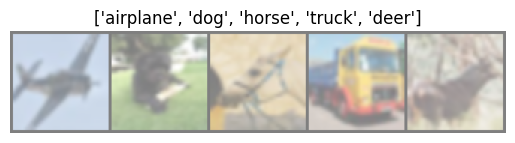

In [ ]:
# Let's visualize a sample batch of images from the training set
images, labels = next(iter(train_loader))  # Get a batch of images and labels

# Visualize the batch of images
imshow(torchvision.utils.make_grid(images[:5]), title=[train_dataset.classes[labels[j]] for j in range(5)])

In [ ]:
# Choose an image from the dataset to test attribution methods

index = 5  # Pick any index you like
image, label = train_dataset[index]
model = PretrainedModel()
#image, _ = train_dataset[0]

# Reshape the image to (1, C, H, W) format
image.unsqueeze_(0)

tensor([[[[0.6235, 0.6157, 0.5961,  ..., 0.2941, 0.2980, 0.2980],
          [0.6078, 0.6039, 0.5882,  ..., 0.3333, 0.3176, 0.3098],
          [0.5725, 0.5765, 0.5765,  ..., 0.4078, 0.3529, 0.3294],
          ...,
          [0.9647, 0.9608, 0.9569,  ..., 0.7059, 0.7333, 0.7451],
          [0.9647, 0.9608, 0.9569,  ..., 0.6941, 0.7137, 0.7255],
          [0.9647, 0.9608, 0.9569,  ..., 0.6863, 0.7059, 0.7137]],

         [[0.4000, 0.3882, 0.3686,  ..., 0.2431, 0.2314, 0.2275],
          [0.3725, 0.3647, 0.3490,  ..., 0.2824, 0.2510, 0.2392],
          [0.3216, 0.3137, 0.3059,  ..., 0.3569, 0.2941, 0.2588],
          ...,
          [0.5294, 0.5255, 0.5137,  ..., 0.2235, 0.2392, 0.2471],
          [0.5412, 0.5373, 0.5255,  ..., 0.2118, 0.2275, 0.2314],
          [0.5451, 0.5412, 0.5294,  ..., 0.2078, 0.2196, 0.2235]],

         [[0.3961, 0.3922, 0.3804,  ..., 0.2157, 0.2157, 0.2157],
          [0.3647, 0.3608, 0.3529,  ..., 0.2471, 0.2314, 0.2235],
          [0.2980, 0.2980, 0.2941,  ..., 0

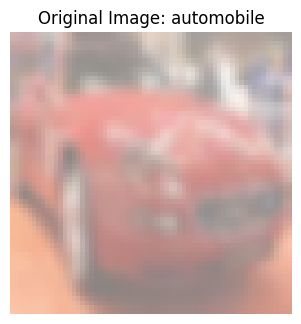

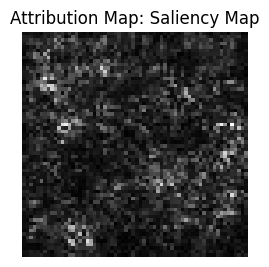

In [ ]:
attribution_map = saliency_map(image, model)
show_attribution(image,label,attribution_map,'Saliency Map')

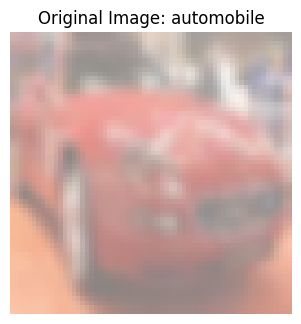

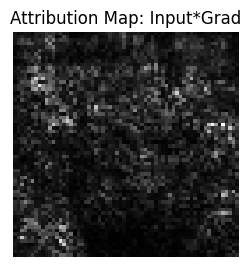

In [ ]:
attribution_map = input_times_grad(image, model)
show_attribution(image,label,attribution_map,'Input*Grad')

In [ ]:
# Excersise: add more attribution methods: smoothgrad, integrated gradients, guided back-propagation, epsilon-LRP